# Smart Production & Prototyping

## Human-in-the-Loop Optimization via Predictive Control for a Behringer Metal Band Saw

# 1. Process Understanding

## 1.1. Introduction to CRISP-DM

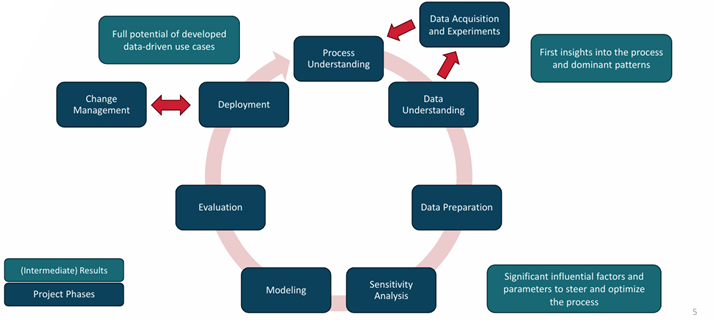

The **Extended CRISP-DM Cycle** is an enhancement of the classical CRISP-DM methodology tailored to industrial data-driven use cases. In addition to data-centric steps, it explicitly incorporates process understanding, experimental data acquisition, sensitivity analysis, and change management. This extension ensures that machine learning solutions are not only technically valid, but also robust, interpretable, and sustainably applicable in real industrial environments.

**Procedure:** <br>
1. **Process Understanding:** <br> The cycle starts with a thorough understanding of the technical process. Physical relationships, relevant control and target variables, operating constraints, and system boundaries are analyzed. This phase establishes the domain knowledge required for meaningful data-driven modeling.

2. **Data Aquisition & Experiments:** <br> Based on the process understanding, structured experiments are planned and executed. Process parameters are systematically varied using design-of-experiments approaches to generate high-quality, representative, and reproducible data.

3. **Data Understanding:** <br> The collected data is explored to gain first insights into process behavior. Patterns, trends, correlations, and dominant influences are identified, while data quality and consistency are assessed.

4. **Data Preparation:** <br> In this phase, raw data is cleaned, synchronized, and transformed into a model-ready format. Feature extraction and aggregation are performed to ensure that the dataset accurately represents the underlying process.

5. **Sensitivity Analysis:** <br> Sensitivity analysis is used to quantify the influence of individual parameters on the target variable. This step helps identify the most relevant control variables and supports focused and effective process optimization.

6. **Modeling:** <br> A data-driven model is developed to describe the relationship between input variables and the target output. The model typically serves as a forward model and forms the basis for prediction, simulation, and optimization.

7. **Modeling:** <br> The model is evaluated with respect to accuracy, robustness, and industrial plausibility. Both quantitative performance metrics and expert knowledge are considered to ensure practical applicability.

8. **Deployment:** <br> After successful evaluation, the model is integrated into the operational system landscape. Predictions or recommendations are made available for use in the running process, often as intermediate results that are further refined during operation.

9. **Change Management:** <br> The final phase ensures sustainable adoption of the solution. User integration, training, acceptance, and continuous improvement are addressed to fully realize the value of the data-driven use case.

## 1.2. Behringer Band Saw

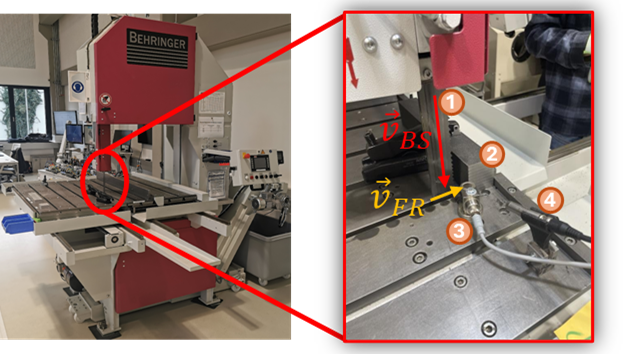

[text required]

## 1.3. Project Objective

**Human-in-the-Loop Optimization via Predictive Control for a Behringer Metal Band Saw**

The objective of this project is the data-driven optimization of the cutting process of a Behringer metal band saw. To achieve this, a machine learning model is developed to predict the electrical current consumption of the saw based on relevant process and sensor data. This predictive model is then embedded into an optimization framework following a predictive control approach in order to derive suitable operating parameters.

Based on the model predictions, concrete recommendations for band velocity and feed rate are generated. The optimization strategy is explicitly designed as a human-in-the-loop approach, meaning that the system provides decision support by suggesting optimal parameter settings, while the final decision and implementation remain with the machine operator. This ensures operational safety, transparency, and acceptance in an industrial environment.

The main control objective is to maintain the electrical current consumption at a constant and optimal level. By stabilizing this target variable, the project aims to improve process stability, reduce energy consumption, and minimize machine wear as well as process-related deviations.

## 1.4. IoT Architecture & End-to-End Data Pipeline

# 2. Data Aquisition & Experiments

[text required]

# 3. Data Understanding & Preparation

## 3.1. Import of Libraries


In [1]:
# === Data Manipulation & Analysis ===
import pandas as pd                      # Data structures and data analysis
import numpy as np                       # Numerical operations and arrays
import math                              # Mathematical functions

# === Data Storage & IO ===
from influxdb_client_3 import InfluxDBClient3   # InfluxDB 3 client for time-series data
import pyarrow.parquet as pq                    # Parquet file read/write support
from pathlib import Path                        # Filesystem path handling

# === Data Visualization ===
import matplotlib.pyplot as plt          # 2D data plotting
import seaborn as sns                    # Statistical data visualization
import missingno as msno                 # Missing data visualization

# === Statistics & Scientific Computing ===
from scipy import stats                  # Statistical tests and distributions

# === Configuration & CLI ===
import argparse                          # Command-line argument parsing

# === Data Structures & Typing ===
from dataclasses import dataclass        # Lightweight data containers
from typing import Optional, Dict, List, Tuple  # Type hints for readability and safety

## 2.2. Import Dataset from InfluxDB

In this step, a data backup is performed from the InfluxDB database. The raw time-series data is exported and stored as a sparse dataset in the influxDB_backup directory located in the root of this repository. The data is saved in Parquet format, ensuring efficient storage and fast downstream processing.

In [3]:
LIMIT = 1_000_000

client = InfluxDBClient3(
    token="apiv3_9EL5Mq-kpLIFd1y3dc9ow0JWWnGPMLM9h6lcFQxQt02FZ-SZis7eJYmj27-E8EKlA_3MTUGa_QBd0holy94oEQ",
    host="http://10.65.1.77:10102",
    database="spp1-main"
)

TABLE_NAME = "saw"
OUTPUT_FILE = "influxDB Backup/saw.backup.parquet"

offset = 0
all_frames = [] # List to store each chunk in memory

print(f"Starting export of '{TABLE_NAME}'...")

while True:
    print(f"Fetching rows {offset} to {offset + LIMIT}...", end="\r")

    # Order by time is critical to ensure pages don't shuffle or overlap
    query = f"""
        SELECT * FROM "{TABLE_NAME}" 
        ORDER BY time ASC
        LIMIT {LIMIT} OFFSET {offset}
    """

    try:
        # Fetch the chunk
        df_chunk = client.query(query=query, mode="pandas")

        # If chunk is empty, we are done
        if df_chunk.empty:
            print(f"\nNo more data found after offset {offset}.")
            break
        
        # Append to our in-memory list
        all_frames.append(df_chunk)

        # Check if this was the last page (less rows than limit)
        if len(df_chunk) < LIMIT:
            print(f"\nReached end of dataset at offset {offset + len(df_chunk)}.")
            break

        # Prepare for next iteration
        offset += LIMIT

    except Exception as e:
        print(f"\nCRITICAL ERROR at offset {offset}: {e}")
        # Depending on importance, you might want to 'break' or 'raise' here
        break

# --- Final Consolidation ---
if all_frames:
    print("Concatenating data...")
    final_df = pd.concat(all_frames, ignore_index=True)

    print(f"Saving {len(final_df)} rows to {OUTPUT_FILE}...")
    final_df.to_parquet(OUTPUT_FILE, index=False)
    print("Export successful.")
else:
    print("No data was retrieved.")

Starting export of 'saw'...
Fetching rows 0 to 1000000...
CRITICAL ERROR at offset 0: Error while executing query: Flight returned unavailable error, with message: failed to connect to all addresses; last error: UNKNOWN: ipv4:10.65.1.77:10102: Failed to connect to remote host: connect() timed out. gRPC client debug context: UNKNOWN:Error received from peer  {created_time:"2026-01-06T09:23:19.079271+01:00", grpc_status:14, grpc_message:"failed to connect to all addresses; last error: UNKNOWN: ipv4:10.65.1.77:10102: Failed to connect to remote host: connect() timed out"}. Client context: IOError: Server never sent a data message. Detail: Internal
No data was retrieved.


## 2.3. Data Conversion: Parquet to CSV

In [4]:
in_path = Path("influxDB Backup/saw.backup.parquet")
out_path = in_path.with_suffix(".csv")

df = pq.read_table(in_path).to_pandas()
df.to_csv(out_path, index=False)

print("Saved to:", out_path.resolve())
print("Exists:", out_path.exists(), "Size:", out_path.stat().st_size if out_path.exists() else None)

Saved to: /Users/vvsmbk/Desktop/all/3 semester classes/Smart Production and Prototyping/Practical Part/gitProject/projectRaphael/influxDB Backup/saw.backup.csv
Exists: True Size: 7143765


## 2.4. Compression and Restructuring of Raw CSV Data

In this step, the raw CSV data is compressed by reorganizing the waterfall-formatted data into a wide format. This transformation eliminates empty cells and results in a more compact and structured dataset suitable for further analysis.

In [3]:
df = pd.read_csv("influxDB Backup/saw_wide_maschineRunning_true.csv")

df["time"] = pd.to_datetime(df["time"])
df["time_1s"] = df["time"].dt.floor("s")   # .dt.round("s") for rounding

value_cols = [c for c in df.columns if c not in ("time", "time_1s")]

out = (
    df.sort_values("time")
      .groupby("time_1s")[value_cols]
      .last()                      # last not-NaN for each column
      .reset_index()
      .rename(columns={"time_1s": "time"})
)

out.to_csv("influxDB Backup/saw_wide.csv", index=False)

## 2.5. Overview of Dataset

### 2.5.1. General Information

In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741 entries, 0 to 3740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time                3741 non-null   datetime64[ns]
 1   bandVelocityActual  3669 non-null   float64       
 2   currentRMS          3737 non-null   float64       
 3   feedRateActual      3674 non-null   float64       
 4   machineRunning      3741 non-null   bool          
 5   microphoneRMS       3738 non-null   float64       
 6   temperatureRMS      3738 non-null   float64       
 7   vibrationRMS        3739 non-null   float64       
 8   time_1s             3741 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(6)
memory usage: 237.6 KB


### 2.5.2. Display Dataset

In [5]:
# Display Dataset
df

,time,bandVelocityActual,currentRMS,feedRateActual,machineRunning,microphoneRMS,temperatureRMS,vibrationRMS,time_1s
0,2025-12-12 14:49:43,2.0,0.886779,390.0,True,0.074864,24.348553,3.503168,2025-12-12 14:49:43
1,2025-12-12 14:49:44,41.0,0.838384,390.0,True,0.084009,24.357191,4.272558,2025-12-12 14:49:44
2,2025-12-12 14:49:45,41.0,0.876621,390.0,True,0.086972,24.344240,3.908590,2025-12-12 14:49:45
3,2025-12-12 14:49:46,41.0,0.960319,390.0,True,0.072588,24.345861,2.589309,2025-12-12 14:49:46
4,2025-12-12 14:49:47,41.0,1.120628,390.0,True,0.082789,24.327732,2.690249,2025-12-12 14:49:47
...,...,...,...,...,...,...,...,...,...
3736,2025-12-12 20:18:55,26.0,0.788912,25.0,True,0.084529,22.739260,2.843599,2025-12-12 20:18:55
3737,2025-12-12 20:18:56,26.0,0.776518,25.0,True,0.085906,22.738646,2.778728,2025-12-12 20:18:56
3738,2025-12-12 20:18:57,26.0,0.758994,25.0,True,0.084631,22.742960,2.813565,2025-12-12 20:18:57
3739,2025-12-12 20:18:58,26.0,0.736839,25.0,True,0.080876,22.737873,2.618505,2025-12-12 20:18:58


### 2.5.3. Numeric Summary

In [6]:
# Describe Dataset
df.describe()

,time,bandVelocityActual,currentRMS,feedRateActual,microphoneRMS,temperatureRMS,vibrationRMS,time_1s
count,3741,3669.000000,3737.000000,3674.000000,3738.000000,3738.000000,3739.000000,3741
mean,2025-12-12 18:54:08.009356032,39.849278,1.775599,51.548476,0.345059,21.705838,28.405915,2025-12-12 18:54:08.009356032
min,2025-12-12 14:49:43,0.000000,0.013048,0.000000,0.020756,17.393789,0.489114,2025-12-12 14:49:43
25%,2025-12-12 18:28:40,26.000000,1.080612,25.000000,0.124543,20.082671,3.401577,2025-12-12 18:28:40
50%,2025-12-12 19:04:03,41.000000,1.455467,39.000000,0.316134,22.724000,27.425570,2025-12-12 19:04:03
75%,2025-12-12 19:45:16,56.000000,2.141462,51.900000,0.479821,23.080530,43.538313,2025-12-12 19:45:16
max,2025-12-12 20:18:59,70.000000,4.984406,390.000000,9.388359,24.357191,267.839142,2025-12-12 20:18:59
std,NaN,12.268751,1.010977,75.146279,0.331858,1.936478,25.524324,NaN


### 2.5.4. Check for Missing Values

Missing values in dataset:  151


/Users/vvsmbk/Desktop/all/3 semester classes/Smart Production and Prototyping/Practical Part/gitProject/projectRaphael/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:81: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


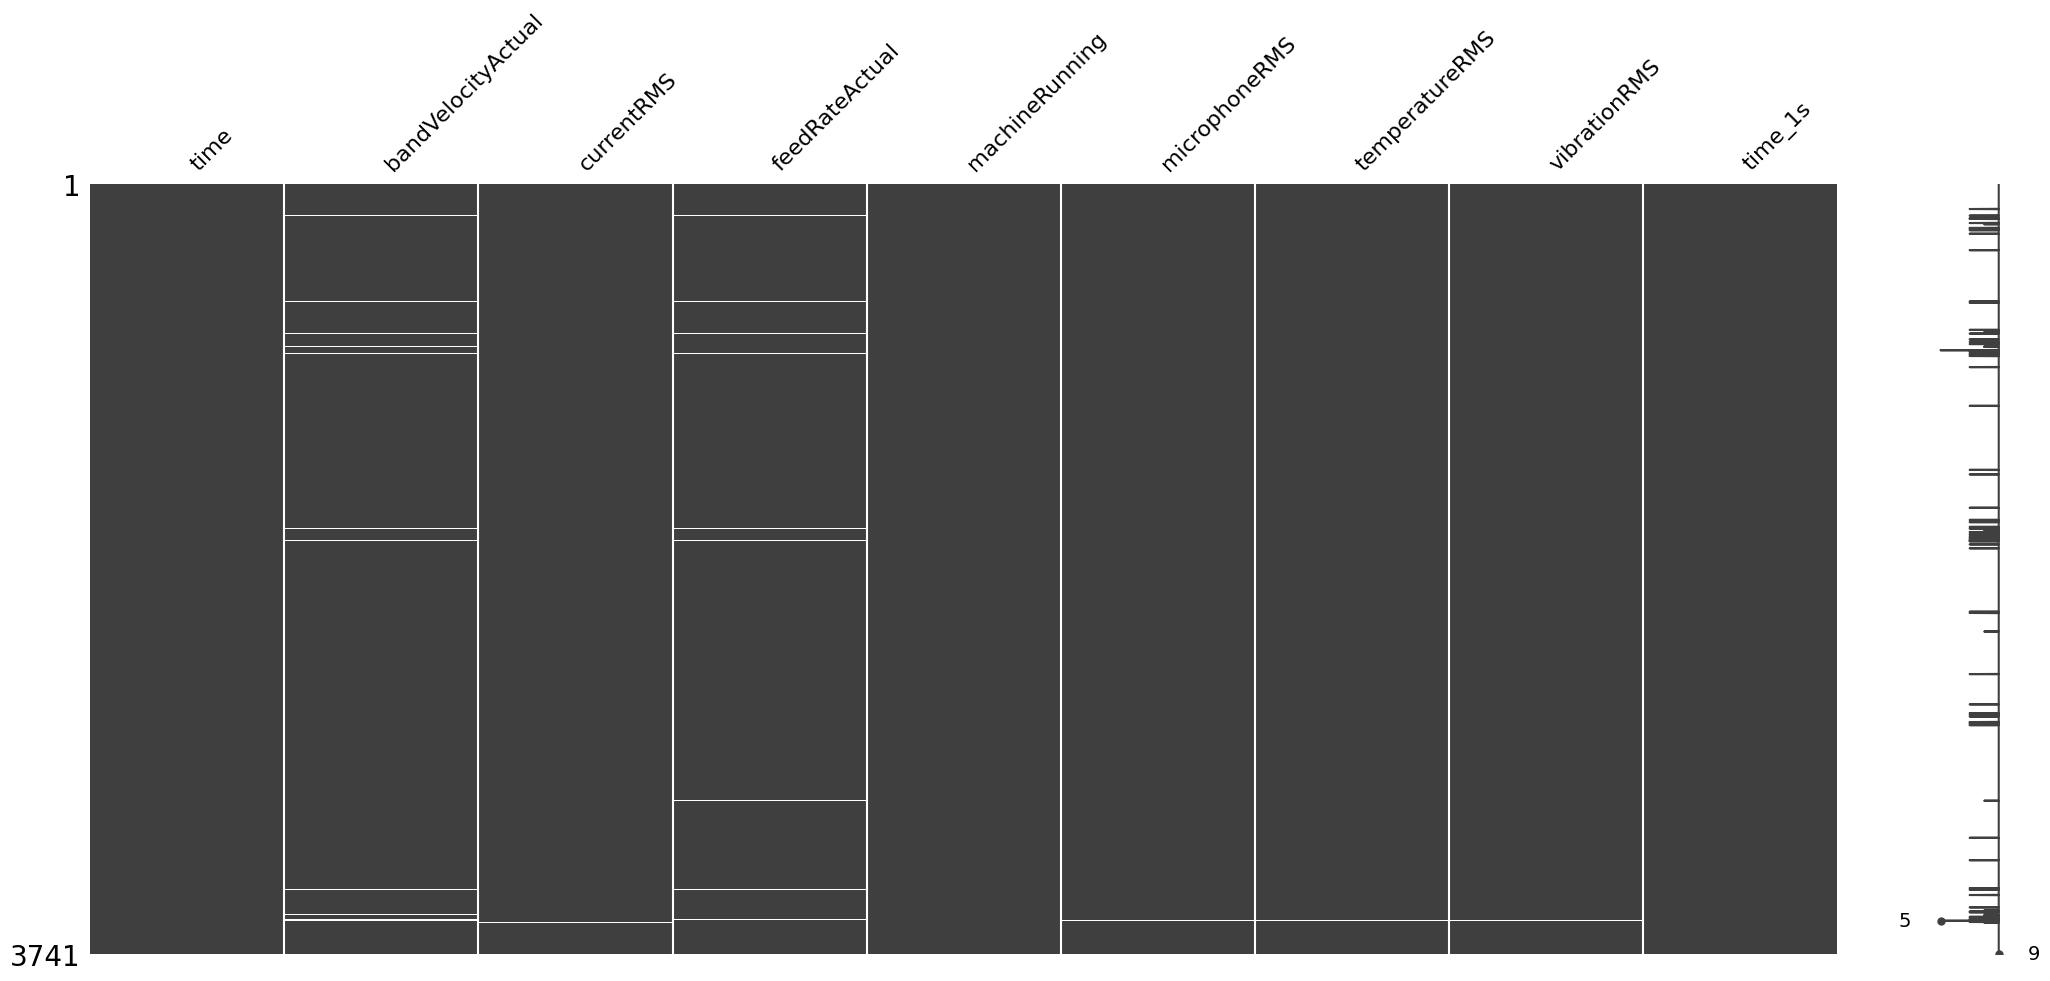

In [7]:
# Visualise missing values using msno
msno.matrix(df)

# Check for missing values
print("Missing values in dataset: ", np.sum(np.sum(df.isnull())))

### 2.5.5. Check for Duplicates

In [8]:
# Check for duplicates using built-in functions
dupes = df.duplicated()
print("The data set contains", sum(dupes), "duplicates.")

The data set contains 0 duplicates.


## 2.6. Visualisations

### 2.6.1. Visualisation of Target

#### 2.6.1.1. Histogram

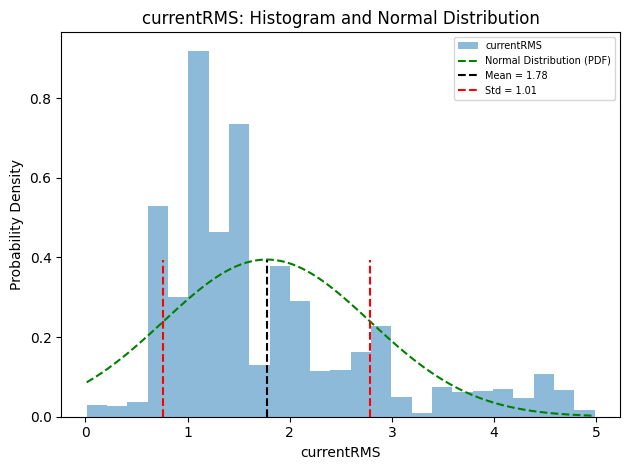

Skewness:  nan
Kurtosis: nan


In [9]:
# Target variable
currentRMS = df["currentRMS"]

# Histogram of target variable
plt.hist(currentRMS, bins=25, density=True, alpha=0.5, label="currentRMS")

# Fit normal distribution
currentRMS_mean = currentRMS.mean()
currentRMS_std = currentRMS.std()
x = np.linspace(currentRMS.min(), currentRMS.max(), 100)
currentRMS_nd_pdf = stats.norm(currentRMS_mean, currentRMS_std).pdf(x)

# Plot normal distribution (PDF)
plt.plot(x, currentRMS_nd_pdf, 'g--', label="Normal Distribution (PDF)")

# Dashed lines for mean and mean ± std
plt.plot([currentRMS_mean, currentRMS_mean],
         [0, currentRMS_nd_pdf.max()],
         'k--', label=f"Mean = {currentRMS_mean:.2f}")

plt.plot([currentRMS_mean - currentRMS_std, currentRMS_mean - currentRMS_std],
         [0, currentRMS_nd_pdf.max()],
         'r--', label=f"Std = {currentRMS_std:.2f}")

plt.plot([currentRMS_mean + currentRMS_std, currentRMS_mean + currentRMS_std],
         [0, currentRMS_nd_pdf.max()],
         'r--')

# Labels and legend
plt.xlabel("currentRMS")
plt.ylabel("Probability Density")
plt.title("currentRMS: Histogram and Normal Distribution")
plt.legend(loc="upper right", fontsize=7)

plt.tight_layout()
plt.show()

# Skewness and kurtosis
currentRMS_skew = stats.skew(currentRMS)
currentRMS_kurt = stats.kurtosis(currentRMS)

print(f"Skewness:  {currentRMS_skew:.4f}")
print(f"Kurtosis: {currentRMS_kurt:.4f}")

#### 2.6.1.2. Boxplot

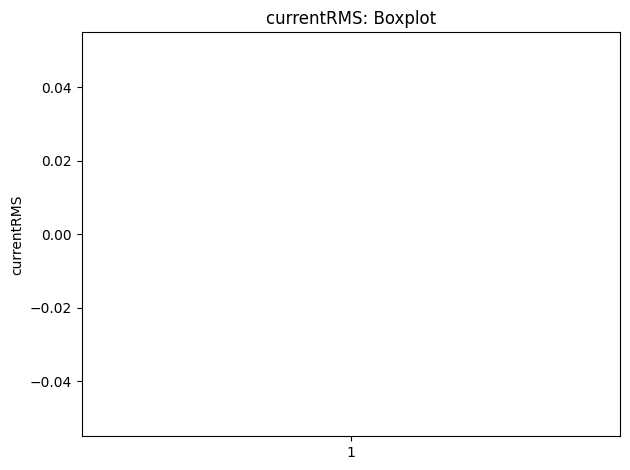

In [12]:
# Boxplot of target variable
plt.boxplot(
    currentRMS,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", color="black")
)

plt.ylabel("currentRMS")
plt.title("currentRMS: Boxplot")
plt.tight_layout()
plt.show()

#### 2.6.1.3. Line Chart

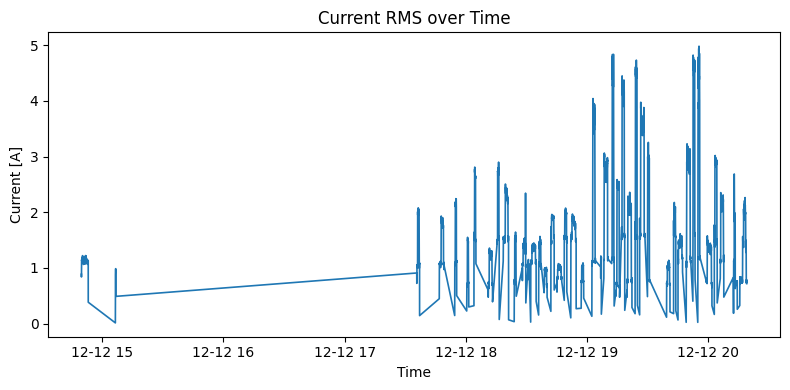

In [13]:
# Line chart: currentRMS over time
plt.figure(figsize=(8, 4))

plt.plot(df["time"], df["currentRMS"], linewidth=1.2)

plt.xlabel("Time")
plt.ylabel("Current [A]")
plt.title("Current RMS over Time")

plt.tight_layout()
plt.show()

### 2.6.2. Visualisation of Features

### 2.6.3. Spearman Correlation Heatmap

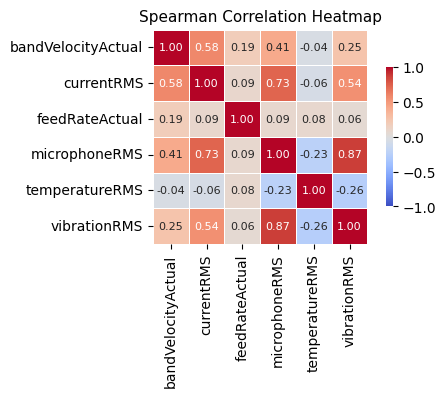

In [14]:
# Select numeric features
numeric_df = df.select_dtypes(include=["number"])

# Compute Spearman correlation matrix
corr_matrix = numeric_df.corr(method="spearman")

# Slightly smaller figure
plt.figure(figsize=(5.2, 4))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.4,
    square=True,
    annot_kws={"size": 8},      # smaller annotation text
    cbar_kws={"shrink": 0.65}   # smaller color bar
)

plt.title("Spearman Correlation Heatmap", fontsize=11)
plt.tight_layout(pad=0.8)
plt.show()